In [170]:
import pandas as pd
import random
import numpy as np
import glob
import os
from unrar import rarfile
import py7zr
import pickle
import datetime
import math

stock_list = pd.read_excel(r'D:\work\project 16 科创50\样本股.xlsx')
stock_list = ('SH' + stock_list['证券代码\nSecurities Code'].astype(str)).values
len(stock_list)
startDate = "20191231"
endDate = "20200724"
readPath = r'D:\work\project 16 科创50\StockFactors\***'
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]

#### 1. 自由流通市值加权（调整股本，分级靠档？），权重因子（单个样本权重不超过10%，前五大样本权重合计不超过40%）

In [171]:
re = {}
for col in ['Date', 'index']:
    re[col] = []
list1 = []
list2 = []
for i in dataPathLs[:1]:
    data = pd.read_csv(i, encoding="GBK")
    data = data[data['Symbol'].isin(stock_list)]
    assert(data.shape[0] == 50)
    data['prob'] = (data['MarketValue'] / data['TotalValue']) * 100
    bins = [0, 15, 20, 30, 40, 50, 60, 70, 80, 100]
    data['cat'] = pd.cut(data['prob'], bins, labels=['<=15', 20, 30, 40, 50, 60, 70, 80, 100])
    data['cat'] = np.where(data['cat'] == '<=15', data['prob'].apply(lambda x: math.ceil(x)), data['cat'])
    assert(len(set(data['cat'][data['cat'] >= 20].unique()) - set([20, 30, 40, 50, 60, 70, 80, 100])) == 0)
    data['divisor'] = data['TotalValue'] * data['cat'] / 100
    divisor = data['divisor'].sum()
    re['Date'].append(data['Date'].iloc[0])
    re['index'].append(1000)

for i in dataPathLs[1:]:
    data = pd.read_csv(i, encoding="GBK")
    data = data[data['Symbol'].isin(stock_list)]
    assert(data.shape[0] == 50)
    data['prob'] = (data['MarketValue'] / data['TotalValue']) * 100
    bins = [0, 15, 20, 30, 40, 50, 60, 70, 80, 100]
    data['cat'] = pd.cut(data['prob'], bins, labels=['<=15', 20, 30, 40, 50, 60, 70, 80, 100])
    data['cat'] = np.where(data['cat'] == '<=15', data['prob'].apply(lambda x: math.ceil(x)), data['cat'])
    assert(len(set(data['cat'][data['cat'] >= 20].unique()) - set([20, 30, 40, 50, 60, 70, 80, 100])) == 0)
    data['new_marketvalue'] = data['TotalValue'] * data['cat'] / 100
    data['p'] = data['new_marketvalue'] / divisor
    data['p1'] = 1
    try:
        assert(data[data['p'] > 0.1].shape[0] == 0)
    except:
        list1.append(data['Date'].iloc[0])
        data['p1'] = np.where(data['p'] > 0.1, 0.1/data['p'], data['p1'])
    data['p'] = data['p'] * data['p1']
    data['new_marketvalue'] = data['new_marketvalue'] * data['p1']
    data['p1'] = 1
    assert(data[data['p'].apply(lambda x: round(x, 4)) > 0.1].shape[0] == 0)
    
    data = data.sort_values(by='p', ascending=False)
    while round(data.iloc[:5, :]['p'].sum(), 4) > 0.4:
        list2.append(data['Date'].iloc[0])
        data.iloc[:5, -1] = 0.4 / (data.iloc[:5, :]['p'].sum()) 
        data['p'] = data['p'] * data['p1']
        data['new_marketvalue'] = data['new_marketvalue'] * data['p1']
        data['p1'] = 1
        data = data.sort_values(by='p', ascending=False)
    re['Date'].append(data['Date'].iloc[0])
    re['index'].append(data['new_marketvalue'].sum() / divisor * 1000)
re = pd.DataFrame(re)
display(re)
display(np.unique(list1))
display(np.unique(list2))

,Date,index
0,20191231,1000.000000
1,20200102,1019.720049
2,20200103,1024.456434
3,20200106,1027.226419
4,20200107,1043.037917
5,20200108,1051.065104
6,20200109,1078.197354
7,20200110,1076.299316
8,20200113,1105.599466
9,20200114,1118.044150


array([20200117, 20200122, 20200123, 20200204, 20200205, 20200206,
       20200207, 20200210, 20200211, 20200212, 20200213, 20200214,
       20200217, 20200218, 20200219, 20200220, 20200221, 20200224,
       20200225, 20200226, 20200227, 20200228, 20200302, 20200303,
       20200304, 20200305, 20200306, 20200309, 20200310, 20200311,
       20200312, 20200313, 20200316, 20200317, 20200318, 20200319,
       20200320, 20200323, 20200324, 20200325, 20200326, 20200327,
       20200330, 20200331, 20200401, 20200402, 20200403, 20200407,
       20200408, 20200409, 20200410, 20200413, 20200414, 20200415,
       20200416, 20200417, 20200420, 20200421, 20200422, 20200423,
       20200424, 20200427, 20200428, 20200429, 20200430, 20200506,
       20200507, 20200508, 20200511, 20200512, 20200513, 20200514,
       20200515, 20200518, 20200519, 20200520, 20200521, 20200522,
       20200525, 20200526, 20200527, 20200528, 20200529, 20200601,
       20200602, 20200603, 20200604, 20200605, 20200608, 20200

array([20200212, 20200213, 20200217, 20200218, 20200219, 20200225,
       20200519, 20200520, 20200526, 20200622, 20200623, 20200624,
       20200629, 20200630, 20200701, 20200702, 20200703, 20200706,
       20200707, 20200708, 20200709, 20200710, 20200713, 20200714,
       20200715, 20200716, 20200717, 20200720, 20200721, 20200722,
       20200723], dtype=int64)

#### 2. 简单加权

In [159]:
re = {}
for col in ['Date', 'index']:
    re[col] = []
for i in dataPathLs[:1]:
    data = pd.read_csv(i, encoding="GBK")
    data = data[data['Symbol'].isin(stock_list)]
    assert(data.shape[0] == 50)
    data['prob'] = (data['MarketValue'] / data['TotalValue']) * 100
    bins = [0, 15, 20, 30, 40, 50, 60, 70, 80, 100]
    data['cat'] = pd.cut(data['prob'], bins, labels=['<=15', 20, 30, 40, 50, 60, 70, 80, 100])
    data['cat'] = np.where(data['cat'] == '<=15', data['prob'].apply(lambda x: math.ceil(x)), data['cat'])
    assert(len(set(data['cat'][data['cat'] >= 20].unique()) - set([20, 30, 40, 50, 60, 70, 80, 100])) == 0)
    data['new_marketvalue'] = data['TotalValue'] * data['cat'] / 100
    divisor = (data['close'] * data['new_marketvalue']).sum() / data['new_marketvalue'].sum()
    re['Date'].append(data['Date'].iloc[0])
    re['index'].append(1000)

for i in dataPathLs[1:2]:
    data = pd.read_csv(i, encoding="GBK")
    data = data[data['Symbol'].isin(stock_list)]
    assert(data.shape[0] == 50)
    data['prob'] = (data['MarketValue'] / data['TotalValue']) * 100
    bins = [0, 15, 20, 30, 40, 50, 60, 70, 80, 100]
    data['cat'] = pd.cut(data['prob'], bins, labels=['<=15', 20, 30, 40, 50, 60, 70, 80, 100])
    data['cat'] = np.where(data['cat'] == '<=15', data['prob'].apply(lambda x: math.ceil(x)), data['cat'])
    assert(len(set(data['cat'][data['cat'] >= 20].unique()) - set([20, 30, 40, 50, 60, 70, 80, 100])) == 0)
    data['new_marketvalue'] = data['TotalValue'] * data['cat'] / 100
    data['p'] = data['new_marketvalue'] / data['new_marketvalue'].sum()
    data['p1'] = 1
    try:
        assert(data[data['p'] > 0.1].shape[0] == 0)
    except:
        list1.append(data['Date'].iloc[0])
        data['p1'] = np.where(data['p'] > 0.1, 0.1/data['p'], data['p1'])
    data['p'] = data['p'] * data['p1']
    data['p1'] = 1
    assert(data[data['p'].apply(lambda x: round(x, 4)) > 0.1].shape[0] == 0)
    
    data = data.sort_values(by='p', ascending=False)
    while round(data.iloc[:5, :]['p'].sum(), 4) > 0.4:
        list2.append(data['Date'].iloc[0])
        data.iloc[:5, -1] = 0.4 / (data.iloc[:5, :]['p'].sum()) 
        data['p'] = data['p'] * data['p1']
        data['p1'] = 1
        data = data.sort_values(by='p', ascending=False)
    re['Date'].append(data['Date'].iloc[0])
    re['index'].append((data['close'] * data['p']).sum() / divisor * 1000)
re = pd.DataFrame(re)
re

,Date,index
0,20191231,1000.000000
1,20200102,1003.496358


In [181]:
np.unique(list2)

array([20200212, 20200213, 20200217, 20200218, 20200219, 20200225,
       20200519, 20200520, 20200526, 20200622, 20200623, 20200624,
       20200629, 20200630, 20200701, 20200702, 20200703, 20200706,
       20200707, 20200708, 20200709, 20200710, 20200713, 20200714,
       20200715, 20200716, 20200717, 20200720, 20200721, 20200722,
       20200723], dtype=int64)

In [182]:
true_index = pd.read_csv(r'D:\work\project 16 科创50\index_daily_SH000688.csv')
true_index = true_index[['Date', 'close']]
pd.set_option('max_rows', 200)
ret = pd.merge(true_index, re, on='Date')
ret['ret1'] = ret['close']/ret['close'].shift(1)-1
ret['ret2'] = ret['index']/ret['index'].shift(1)-1
ret['diff'] = (ret['ret1'] - ret['ret2']).apply(lambda x: abs(x)*100)
ret = ret.fillna(0)
ret['diff'].describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    135.000000
mean       0.746814
std        3.691057
min        0.000000
1%         0.000429
5%         0.002237
10%        0.023869
25%        0.134501
50%        0.283320
75%        0.557585
90%        1.053569
95%        1.497198
99%        2.879769
max       42.945609
Name: diff, dtype: float64

In [183]:
ret

,Date,close,index,ret1,ret2,diff
0,20191231,1000.0000,1000.000000,0.000000,0.000000,0.000000
1,20200102,1019.7234,1019.720049,0.019723,0.019720,0.000335
2,20200103,1024.4819,1024.456434,0.004666,0.004645,0.002167
3,20200106,1027.2773,1027.226419,0.002729,0.002704,0.002474
4,20200107,1043.0833,1043.037917,0.015386,0.015392,0.000611
5,20200108,1051.1599,1051.065104,0.007743,0.007696,0.004704
6,20200109,1078.3117,1078.197354,0.025830,0.025814,0.001627
7,20200110,1076.4379,1076.299316,-0.001738,-0.001760,0.002266
8,20200113,1105.8481,1105.599466,0.027322,0.027223,0.009873
9,20200114,1118.3063,1118.044150,0.011266,0.011256,0.000969


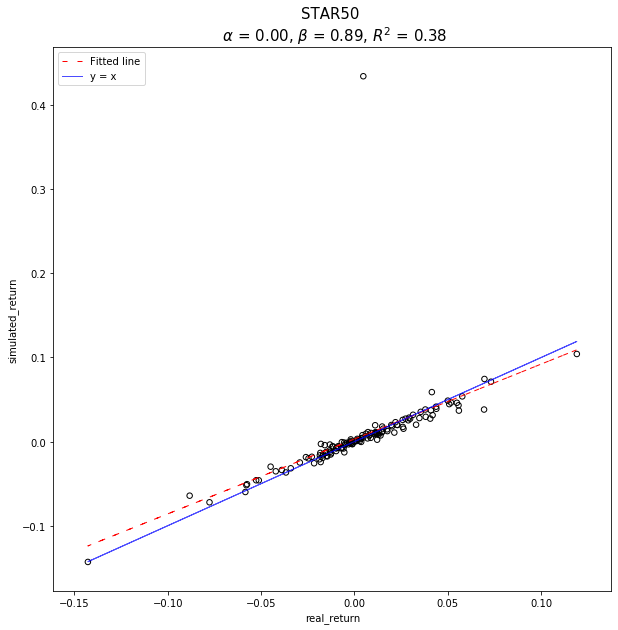

In [214]:
import statsmodels.api as sm 
import matplotlib.pyplot as plt

x = ret['ret1'].values
y = ret['ret2'].values
m, b = np.polyfit(x, y, 1)
regress = sm.OLS(y, sm.add_constant(x)).fit()
        
x_sub = ret['ret1'].values
y_sub = ret['ret2'].values

# plot
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(x_sub, y_sub, marker = 'o', s = 30, c='',edgecolors='black')
ax.set_xlabel('real_return')
ax.set_ylabel('simulated_return')

# Fit with polyfit
ax.plot(x_sub, b + m * x_sub, linestyle = '--', color = 'red', alpha = 1, linewidth = 1, dashes=(5, 10), label = 'Fitted line')
ax.plot(x_sub, x_sub, linestyle = '-', color = 'blue', linewidth = 1, alpha = 0.7, label = 'y = x')
ax.legend(loc = 'upper left')
ax.set_title('%s \n $\\alpha$ = %.2f, $\\beta$ = %.2f, $R^2$ = %.2f' % ('STAR50', regress.params[0], regress.params[1], regress.rsquared), fontsize = 15)
plt.show()

In [213]:
m

0.0031092806934672344